# CogPonder: A Model-Agnostic Approach to Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of human responses.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate a model-agnostic neural network that produces the speed-accuracy of the human decision making.

The network iterates over a recurrent decision model, terminating only when it reaches a halting step. Halting step is a decision step that is made when the network is confident enough to make a decision. The network is trained to minimize the difference between the human response time and the network's response time.


## Tasks

### 2-back Task

The subject is presented with a sequence of letters, and are asked to respond with "target" button whe the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock 2-back dataset to evaluate the architecture. The mock dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$ for each subject.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each time step is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution).

In case of the 2-back task, X is a moving window of recent 2 stimuli symbols, e.g., A, B, C, D, ...; and $y$ is either MATCH or NON_MATCH.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch.


### Criterion

$L = L_{rec} + L_{reg} + L_{target} + L_{non\_target}$ 


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from cogponder import NBackDataset, PonderNet, ICOM, evaluate

## Data

In [2]:


# generate mock n-back data

n_stimuli = 6

dataset = NBackDataset(n_subjects=2, n_trials=100, n_stimuli=6)

X, targets, responses, response_times = dataset[0]
dataset = TensorDataset(X, targets.float(), responses, response_times)

In [3]:
# evaluate the model

N_EPOCHS = 100
MAX_STEPS = response_times.max().detach() + 10
N_OUTPUTS = torch.unique(targets).size()[0]
LAMBDA_P = 1 / response_times.detach().median()

model = PonderNet(ICOM, n_stimuli+1, n_stimuli, N_OUTPUTS, MAX_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = evaluate(model, dataset, optimizer, n_epochs=N_EPOCHS,
                   lambda_p=LAMBDA_P,
                   batch_size=4, max_steps=MAX_STEPS)

model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results

Epochs:   3%|▎         | 3/100 [00:00<00:03, 24.57it/s]

lambda_n tensor([0.5626, 0.5436, 0.5363, 0.5249, 0.5369, 0.5341, 0.5414, 0.5330, 0.5242,
        0.5521, 0.5390, 0.5435, 0.5368, 0.5331, 0.5398, 0.5614, 0.5627, 0.5654,
        0.5654, 0.5392, 0.5393, 0.5389, 0.5241, 0.5343, 0.5383, 0.5351, 0.5523,
        0.5387, 0.5435, 0.5424, 0.5452, 0.5322, 0.5425, 0.5305, 0.5333, 0.5348,
        0.5334, 0.5605, 0.5616, 0.5458, 0.5363, 0.5324, 0.5437, 0.5382, 0.5639,
        0.5436, 0.5294, 0.5369, 0.5409, 0.5257, 0.5521, 0.5523, 0.5418, 0.5435,
        0.5626, 0.5557, 0.5563, 0.5550, 0.5357, 0.5380, 0.5512, 0.5326, 0.5633,
        0.5545, 0.5432, 0.5432, 0.5257, 0.5596, 0.5352, 0.5445, 0.5410, 0.5423,
        0.5423, 0.5357, 0.5364, 0.5318, 0.5331, 0.5402])
lambda_n tensor([0.5672, 0.5465, 0.5386, 0.5246, 0.5367, 0.5338, 0.5432, 0.5349, 0.5231,
        0.5540, 0.5402, 0.5439, 0.5376, 0.5329, 0.5404, 0.5655, 0.5679, 0.5704,
        0.5704, 0.5392, 0.5393, 0.5408, 0.5239, 0.5333, 0.5388, 0.5358, 0.5563,
        0.5401, 0.5439, 0.5447, 0.5490, 0.531

Epochs:  11%|█         | 11/100 [00:00<00:02, 35.85it/s]

lambda_n tensor([0.5264, 0.5482, 0.5299, 0.5392, 0.5300, 0.5374, 0.5362, 0.5227, 0.5326,
        0.5209, 0.5455, 0.5541, 0.5351, 0.5506, 0.5294, 0.5370, 0.5358, 0.5405,
        0.5471, 0.5331])
lambda_n tensor([0.5282, 0.5518, 0.5310, 0.5401, 0.5304, 0.5390, 0.5389, 0.5245, 0.5348,
        0.5225, 0.5492, 0.5602, 0.5368, 0.5555, 0.5315, 0.5385, 0.5390, 0.5452,
        0.5513, 0.5346])
lambda_n tensor([0.5280, 0.5514, 0.5307, 0.5396, 0.5300, 0.5385, 0.5382, 0.5242, 0.5343,
        0.5222, 0.5487, 0.5598, 0.5364, 0.5549, 0.5312, 0.5380, 0.5384, 0.5449,
        0.5509, 0.5342])
lambda_n tensor([0.5582, 0.5388, 0.5314, 0.5214, 0.5332, 0.5297, 0.5360, 0.5278, 0.5202,
        0.5473, 0.5351, 0.5398, 0.5333, 0.5287, 0.5355, 0.5568, 0.5584, 0.5613,
        0.5613, 0.5353, 0.5358, 0.5338, 0.5196, 0.5307, 0.5343, 0.5314, 0.5478,
        0.5347, 0.5398, 0.5374, 0.5405, 0.5282, 0.5373, 0.5264, 0.5294, 0.5301,
        0.5287, 0.5554, 0.5571, 0.5412, 0.5314, 0.5275, 0.5392, 0.5346, 0.5595,
        0

Epochs:  21%|██        | 21/100 [00:00<00:02, 34.83it/s]

lambda_n tensor([0.5209, 0.5433, 0.5245, 0.5344, 0.5252, 0.5322, 0.5308, 0.5177, 0.5275,
        0.5156, 0.5406, 0.5478, 0.5311, 0.5456, 0.5245, 0.5325, 0.5302, 0.5344,
        0.5418, 0.5287])
lambda_n tensor([0.5241, 0.5485, 0.5271, 0.5369, 0.5272, 0.5353, 0.5349, 0.5207, 0.5312,
        0.5185, 0.5457, 0.5553, 0.5339, 0.5520, 0.5278, 0.5354, 0.5348, 0.5405,
        0.5474, 0.5314])
lambda_n tensor([0.5240, 0.5481, 0.5269, 0.5365, 0.5269, 0.5349, 0.5344, 0.5205, 0.5308,
        0.5183, 0.5453, 0.5550, 0.5337, 0.5515, 0.5275, 0.5350, 0.5343, 0.5403,
        0.5472, 0.5312])
lambda_n tensor([0.5240, 0.5481, 0.5269, 0.5365, 0.5269, 0.5349, 0.5344, 0.5205, 0.5308,
        0.5183, 0.5453, 0.5549, 0.5337, 0.5515, 0.5275, 0.5350, 0.5343, 0.5402,
        0.5472, 0.5312])
lambda_n tensor([0.5240, 0.5481, 0.5269, 0.5365, 0.5269, 0.5349, 0.5344, 0.5205, 0.5308,
        0.5183, 0.5453, 0.5550, 0.5337, 0.5515, 0.5275, 0.5350, 0.5343, 0.5402,
        0.5472, 0.5312])
lambda_n tensor([0.5240, 0.548

Epochs:  25%|██▌       | 25/100 [00:00<00:02, 33.07it/s]

lambda_n tensor([0.5211, 0.5460, 0.5243, 0.5344, 0.5250, 0.5323, 0.5320, 0.5178, 0.5287,
        0.5155, 0.5431, 0.5512, 0.5317, 0.5491, 0.5249, 0.5329, 0.5317, 0.5368,
        0.5444, 0.5290])
lambda_n tensor([0.5211, 0.5459, 0.5243, 0.5344, 0.5250, 0.5323, 0.5320, 0.5178, 0.5287,
        0.5154, 0.5431, 0.5512, 0.5317, 0.5491, 0.5248, 0.5329, 0.5317, 0.5368,
        0.5444, 0.5290])
lambda_n tensor([0.5211, 0.5459, 0.5243, 0.5344, 0.5250, 0.5323, 0.5320, 0.5178, 0.5287,
        0.5155, 0.5431, 0.5512, 0.5317, 0.5491, 0.5249, 0.5329, 0.5317, 0.5368,
        0.5444, 0.5290])
lambda_n tensor([0.5211, 0.5459, 0.5243, 0.5344, 0.5250, 0.5323, 0.5320, 0.5178, 0.5287,
        0.5155, 0.5431, 0.5512, 0.5317, 0.5491, 0.5249, 0.5329, 0.5317, 0.5368,
        0.5444, 0.5290])
lambda_n tensor([0.5484, 0.5295, 0.5217, 0.5139, 0.5258, 0.5212, 0.5263, 0.5177, 0.5122,
        0.5385, 0.5262, 0.5325, 0.5260, 0.5204, 0.5263, 0.5471, 0.5482, 0.5517,
        0.5517, 0.5277, 0.5287, 0.5248, 0.5097, 0.5237,

Epochs:  33%|███▎      | 33/100 [00:01<00:02, 30.16it/s]

lambda_n tensor([0.5528, 0.5320, 0.5238, 0.5144, 0.5267, 0.5217, 0.5280, 0.5194, 0.5125,
        0.5412, 0.5276, 0.5338, 0.5273, 0.5209, 0.5270, 0.5510, 0.5526, 0.5558,
        0.5558, 0.5286, 0.5296, 0.5268, 0.5097, 0.5240, 0.5273, 0.5248, 0.5428,
        0.5264, 0.5338, 0.5307, 0.5328, 0.5210, 0.5301, 0.5179, 0.5232, 0.5216,
        0.5203, 0.5477, 0.5512, 0.5351, 0.5238, 0.5201, 0.5323, 0.5276, 0.5542,
        0.5320, 0.5189, 0.5267, 0.5288, 0.5119, 0.5412, 0.5412, 0.5309, 0.5338,
        0.5528, 0.5459, 0.5462, 0.5444, 0.5238, 0.5276, 0.5411, 0.5190, 0.5516,
        0.5446, 0.5327, 0.5323, 0.5119, 0.5478, 0.5238, 0.5338, 0.5304, 0.5319,
        0.5319, 0.5241, 0.5252, 0.5196, 0.5193, 0.5265])
lambda_n tensor([0.5528, 0.5320, 0.5238, 0.5144, 0.5267, 0.5217, 0.5280, 0.5194, 0.5125,
        0.5412, 0.5276, 0.5338, 0.5273, 0.5209, 0.5270, 0.5510, 0.5526, 0.5558,
        0.5558, 0.5286, 0.5296, 0.5268, 0.5097, 0.5240, 0.5273, 0.5248, 0.5428,
        0.5264, 0.5338, 0.5307, 0.5328, 0.521

Epochs:  37%|███▋      | 37/100 [00:01<00:02, 28.95it/s]

lambda_n tensor([0.5078, 0.5321, 0.5119, 0.5232, 0.5147, 0.5198, 0.5193, 0.5057, 0.5170,
        0.5034, 0.5293, 0.5317, 0.5215, 0.5342, 0.5129, 0.5223, 0.5182, 0.5195,
        0.5289, 0.5183])
lambda_n tensor([0.5139, 0.5400, 0.5174, 0.5287, 0.5200, 0.5260, 0.5261, 0.5113, 0.5234,
        0.5087, 0.5373, 0.5418, 0.5267, 0.5432, 0.5186, 0.5279, 0.5254, 0.5280,
        0.5369, 0.5235])
lambda_n tensor([0.5141, 0.5401, 0.5177, 0.5288, 0.5201, 0.5260, 0.5261, 0.5114, 0.5236,
        0.5088, 0.5373, 0.5418, 0.5267, 0.5430, 0.5186, 0.5278, 0.5253, 0.5282,
        0.5372, 0.5235])
lambda_n tensor([0.5141, 0.5401, 0.5177, 0.5288, 0.5201, 0.5260, 0.5261, 0.5114, 0.5236,
        0.5088, 0.5373, 0.5418, 0.5267, 0.5430, 0.5186, 0.5278, 0.5253, 0.5282,
        0.5372, 0.5235])
lambda_n tensor([0.5141, 0.5401, 0.5177, 0.5288, 0.5201, 0.5260, 0.5261, 0.5114, 0.5236,
        0.5088, 0.5373, 0.5418, 0.5267, 0.5430, 0.5186, 0.5278, 0.5254, 0.5282,
        0.5372, 0.5235])
lambda_n tensor([0.5141, 0.540

Epochs:  40%|████      | 40/100 [00:01<00:02, 25.36it/s]

lambda_n tensor([0.5336, 0.5162, 0.5078, 0.5029, 0.5153, 0.5095, 0.5129, 0.5036, 0.5003,
        0.5255, 0.5128, 0.5215, 0.5158, 0.5089, 0.5131, 0.5323, 0.5323, 0.5364,
        0.5364, 0.5160, 0.5183, 0.5128, 0.4958, 0.5137, 0.5146, 0.5134, 0.5259,
        0.5115, 0.5215, 0.5160, 0.5144, 0.5089, 0.5158, 0.5032, 0.5125, 0.5087,
        0.5078, 0.5286, 0.5313, 0.5197, 0.5078, 0.5054, 0.5157, 0.5144, 0.5362,
        0.5162, 0.5065, 0.5153, 0.5141, 0.4980, 0.5255, 0.5229, 0.5170, 0.5215,
        0.5336, 0.5277, 0.5281, 0.5267, 0.5110, 0.5166, 0.5248, 0.5052, 0.5331,
        0.5269, 0.5185, 0.5184, 0.4980, 0.5301, 0.5108, 0.5207, 0.5173, 0.5185,
        0.5185, 0.5117, 0.5131, 0.5079, 0.5064, 0.5121])
lambda_n tensor([0.5444, 0.5242, 0.5154, 0.5083, 0.5213, 0.5154, 0.5206, 0.5112, 0.5056,
        0.5338, 0.5200, 0.5280, 0.5223, 0.5149, 0.5199, 0.5427, 0.5431, 0.5465,
        0.5465, 0.5218, 0.5242, 0.5204, 0.5016, 0.5190, 0.5214, 0.5196, 0.5358,
        0.5185, 0.5280, 0.5239, 0.5234, 0.514

Epochs:  46%|████▌     | 46/100 [00:01<00:02, 25.46it/s]

lambda_n tensor([0.5293, 0.5123, 0.5037, 0.4996, 0.5121, 0.5059, 0.5090, 0.4995, 0.4967,
        0.5216, 0.5088, 0.5181, 0.5128, 0.5055, 0.5092, 0.5279, 0.5277, 0.5319,
        0.5319, 0.5123, 0.5150, 0.5093, 0.4917, 0.5105, 0.5112, 0.5104, 0.5222,
        0.5075, 0.5181, 0.5123, 0.5099, 0.5053, 0.5121, 0.4991, 0.5093, 0.5048,
        0.5041, 0.5239, 0.5267, 0.5158, 0.5037, 0.5016, 0.5116, 0.5106, 0.5320,
        0.5123, 0.5029, 0.5121, 0.5105, 0.4939, 0.5216, 0.5185, 0.5131, 0.5181,
        0.5293, 0.5236, 0.5238, 0.5225, 0.5072, 0.5134, 0.5211, 0.5012, 0.5285,
        0.5228, 0.5146, 0.5149, 0.4939, 0.5256, 0.5071, 0.5169, 0.5138, 0.5149,
        0.5149, 0.5081, 0.5096, 0.5045, 0.5026, 0.5083])
lambda_n tensor([0.5405, 0.5207, 0.5116, 0.5055, 0.5187, 0.5125, 0.5172, 0.5076, 0.5025,
        0.5304, 0.5166, 0.5251, 0.5198, 0.5121, 0.5166, 0.5388, 0.5389, 0.5423,
        0.5423, 0.5186, 0.5215, 0.5174, 0.4981, 0.5164, 0.5186, 0.5171, 0.5325,
        0.5150, 0.5251, 0.5207, 0.5193, 0.511

Epochs:  54%|█████▍    | 54/100 [00:01<00:01, 30.09it/s]

lambda_n tensor([0.5340, 0.5148, 0.5054, 0.5007, 0.5142, 0.5075, 0.5115, 0.5016, 0.4973,
        0.5245, 0.5108, 0.5202, 0.5155, 0.5073, 0.5110, 0.5323, 0.5318, 0.5351,
        0.5351, 0.5132, 0.5168, 0.5123, 0.4924, 0.5120, 0.5139, 0.5129, 0.5270,
        0.5091, 0.5202, 0.5153, 0.5125, 0.5059, 0.5143, 0.5008, 0.5108, 0.5062,
        0.5057, 0.5273, 0.5306, 0.5180, 0.5054, 0.5031, 0.5135, 0.5118, 0.5359,
        0.5148, 0.5040, 0.5142, 0.5134, 0.4948, 0.5245, 0.5219, 0.5143, 0.5202,
        0.5340, 0.5273, 0.5266, 0.5252, 0.5077, 0.5149, 0.5255, 0.5020, 0.5315,
        0.5264, 0.5158, 0.5176, 0.4948, 0.5284, 0.5089, 0.5184, 0.5164, 0.5176,
        0.5176, 0.5100, 0.5116, 0.5065, 0.5038, 0.5107])
lambda_n tensor([0.5342, 0.5153, 0.5061, 0.5014, 0.5148, 0.5083, 0.5119, 0.5021, 0.4982,
        0.5250, 0.5113, 0.5207, 0.5156, 0.5079, 0.5115, 0.5325, 0.5321, 0.5355,
        0.5355, 0.5140, 0.5170, 0.5127, 0.4934, 0.5125, 0.5142, 0.5131, 0.5273,
        0.5098, 0.5207, 0.5157, 0.5131, 0.506

Epochs:  62%|██████▏   | 62/100 [00:02<00:01, 32.21it/s]

lambda_n tensor([0.5135, 0.4979, 0.4888, 0.4869, 0.4998, 0.4927, 0.4946, 0.4846, 0.4827,
        0.5068, 0.4939, 0.5050, 0.5012, 0.4927, 0.4947, 0.5119, 0.5111, 0.5153,
        0.5153, 0.4984, 0.5024, 0.4964, 0.4768, 0.4983, 0.4984, 0.4990, 0.5087,
        0.4929, 0.5050, 0.4989, 0.4937, 0.4913, 0.4981, 0.4841, 0.4966, 0.4904,
        0.4898, 0.5067, 0.5099, 0.5016, 0.4888, 0.4874, 0.4962, 0.4964, 0.5163,
        0.4979, 0.4897, 0.4998, 0.4972, 0.4789, 0.5068, 0.5026, 0.4985, 0.5050,
        0.5135, 0.5084, 0.5079, 0.5068, 0.4927, 0.5008, 0.5073, 0.4865, 0.5117,
        0.5075, 0.4999, 0.5017, 0.4789, 0.5091, 0.4931, 0.5026, 0.5003, 0.5016,
        0.5016, 0.4947, 0.4966, 0.4917, 0.4883, 0.4940])
lambda_n tensor([0.5254, 0.5070, 0.4973, 0.4942, 0.5080, 0.5008, 0.5040, 0.4937, 0.4900,
        0.5165, 0.5031, 0.5134, 0.5096, 0.5008, 0.5036, 0.5237, 0.5226, 0.5258,
        0.5258, 0.5058, 0.5102, 0.5056, 0.4848, 0.5058, 0.5074, 0.5072, 0.5197,
        0.5015, 0.5134, 0.5081, 0.5037, 0.498

Epochs:  66%|██████▌   | 66/100 [00:02<00:01, 32.52it/s]

tensor([0.5169, 0.4998, 0.4895, 0.4881, 0.5023, 0.4951, 0.4968, 0.4864, 0.4834,
        0.5089, 0.4958, 0.5068, 0.5038, 0.4951, 0.4968, 0.5153, 0.5136, 0.5166,
        0.5166, 0.4990, 0.5036, 0.4994, 0.4784, 0.4999, 0.5014, 0.5017, 0.5126,
        0.4944, 0.5068, 0.5014, 0.4955, 0.4919, 0.4996, 0.4859, 0.4985, 0.4923,
        0.4921, 0.5093, 0.5125, 0.5027, 0.4895, 0.4883, 0.4972, 0.4973, 0.5187,
        0.4998, 0.4904, 0.5023, 0.5000, 0.4803, 0.5089, 0.5049, 0.4991, 0.5068,
        0.5169, 0.5109, 0.5090, 0.5079, 0.4931, 0.5021, 0.5112, 0.4879, 0.5131,
        0.5102, 0.5002, 0.5037, 0.4803, 0.5108, 0.4952, 0.5035, 0.5031, 0.5042,
        0.5042, 0.4971, 0.4986, 0.4946, 0.4903, 0.4964])
lambda_n tensor([0.5170, 0.4998, 0.4896, 0.4881, 0.5023, 0.4952, 0.4968, 0.4864, 0.4834,
        0.5089, 0.4958, 0.5069, 0.5039, 0.4952, 0.4968, 0.5154, 0.5136, 0.5166,
        0.5166, 0.4990, 0.5037, 0.4995, 0.4784, 0.4999, 0.5014, 0.5018, 0.5127,
        0.4945, 0.5069, 0.5015, 0.4955, 0.4919, 0.4997

Epochs:  70%|███████   | 70/100 [00:02<00:01, 26.52it/s]

lambda_n tensor([0.4700, 0.4971, 0.4745, 0.4874, 0.4813, 0.4829, 0.4857, 0.4714, 0.4858,
        0.4695, 0.4958, 0.4887, 0.4908, 0.5003, 0.4801, 0.4909, 0.4850, 0.4788,
        0.4904, 0.4856])
lambda_n tensor([0.4798, 0.5072, 0.4834, 0.4961, 0.4912, 0.4927, 0.4954, 0.4803, 0.4950,
        0.4781, 0.5061, 0.4996, 0.4988, 0.5106, 0.4887, 0.4997, 0.4945, 0.4889,
        0.4996, 0.4935])
lambda_n tensor([0.4806, 0.5080, 0.4845, 0.4969, 0.4921, 0.4935, 0.4961, 0.4812, 0.4959,
        0.4792, 0.5069, 0.5002, 0.4995, 0.5112, 0.4896, 0.5006, 0.4953, 0.4896,
        0.5003, 0.4943])
lambda_n tensor([0.4806, 0.5080, 0.4845, 0.4969, 0.4922, 0.4936, 0.4961, 0.4812, 0.4959,
        0.4793, 0.5070, 0.5002, 0.4996, 0.5112, 0.4897, 0.5006, 0.4954, 0.4896,
        0.5003, 0.4943])
lambda_n tensor([0.4806, 0.5080, 0.4845, 0.4969, 0.4922, 0.4936, 0.4961, 0.4812, 0.4959,
        0.4793, 0.5070, 0.5002, 0.4996, 0.5112, 0.4897, 0.5006, 0.4955, 0.4896,
        0.5003, 0.4943])
lambda_n tensor([0.4806, 0.508

Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 27.27it/s]

lambda_n tensor([0.4939, 0.4806, 0.4705, 0.4705, 0.4837, 0.4762, 0.4771, 0.4667, 0.4653,
        0.4884, 0.4750, 0.4879, 0.4857, 0.4764, 0.4765, 0.4921, 0.4907, 0.4949,
        0.4949, 0.4809, 0.4855, 0.4805, 0.4586, 0.4821, 0.4818, 0.4840, 0.4916,
        0.4743, 0.4879, 0.4824, 0.4740, 0.4735, 0.4810, 0.4654, 0.4802, 0.4724,
        0.4721, 0.4858, 0.4894, 0.4843, 0.4705, 0.4701, 0.4774, 0.4781, 0.4967,
        0.4806, 0.4723, 0.4837, 0.4811, 0.4605, 0.4884, 0.4829, 0.4798, 0.4879,
        0.4939, 0.4897, 0.4881, 0.4872, 0.4745, 0.4841, 0.4900, 0.4683, 0.4910,
        0.4888, 0.4810, 0.4854, 0.4605, 0.4888, 0.4757, 0.4841, 0.4830, 0.4844,
        0.4844, 0.4778, 0.4797, 0.4755, 0.4706, 0.4768])
lambda_n tensor([0.5055, 0.4898, 0.4790, 0.4786, 0.4930, 0.4855, 0.4871, 0.4764, 0.4733,
        0.4982, 0.4851, 0.4969, 0.4951, 0.4858, 0.4864, 0.5040, 0.5016, 0.5044,
        0.5044, 0.4885, 0.4940, 0.4906, 0.4679, 0.4907, 0.4922, 0.4932, 0.5027,
        0.4835, 0.4969, 0.4921, 0.4841, 0.481

Epochs:  82%|████████▏ | 82/100 [00:02<00:00, 27.42it/s]

lambda_n tensor([0.4618, 0.4897, 0.4663, 0.4792, 0.4742, 0.4745, 0.4789, 0.4633, 0.4795,
        0.4614, 0.4885, 0.4791, 0.4835, 0.4926, 0.4719, 0.4834, 0.4781, 0.4702,
        0.4821, 0.4776])
lambda_n tensor([0.4722, 0.4997, 0.4759, 0.4882, 0.4848, 0.4849, 0.4892, 0.4729, 0.4890,
        0.4709, 0.4989, 0.4898, 0.4918, 0.5028, 0.4812, 0.4926, 0.4882, 0.4804,
        0.4911, 0.4858])
lambda_n tensor([0.4729, 0.5004, 0.4770, 0.4889, 0.4858, 0.4857, 0.4898, 0.4739, 0.4899,
        0.4721, 0.4998, 0.4904, 0.4926, 0.5033, 0.4823, 0.4936, 0.4891, 0.4811,
        0.4918, 0.4866])
lambda_n tensor([0.4729, 0.5005, 0.4770, 0.4889, 0.4858, 0.4858, 0.4899, 0.4739, 0.4900,
        0.4722, 0.4998, 0.4904, 0.4927, 0.5034, 0.4824, 0.4937, 0.4892, 0.4811,
        0.4918, 0.4866])
lambda_n tensor([0.4729, 0.5005, 0.4770, 0.4889, 0.4858, 0.4858, 0.4899, 0.4739, 0.4900,
        0.4722, 0.4998, 0.4904, 0.4927, 0.5034, 0.4824, 0.4937, 0.4892, 0.4811,
        0.4918, 0.4866])
lambda_n tensor([0.4729, 0.500

Epochs:  89%|████████▉ | 89/100 [00:03<00:00, 25.03it/s]

lambda_n tensor([0.4879, 0.4766, 0.4661, 0.4658, 0.4790, 0.4717, 0.4731, 0.4628, 0.4613,
        0.4840, 0.4694, 0.4829, 0.4805, 0.4720, 0.4709, 0.4864, 0.4849, 0.4892,
        0.4892, 0.4765, 0.4801, 0.4768, 0.4538, 0.4774, 0.4767, 0.4787, 0.4865,
        0.4683, 0.4829, 0.4784, 0.4685, 0.4692, 0.4773, 0.4602, 0.4764, 0.4677,
        0.4678, 0.4799, 0.4839, 0.4804, 0.4661, 0.4665, 0.4728, 0.4729, 0.4910,
        0.4766, 0.4667, 0.4790, 0.4771, 0.4557, 0.4840, 0.4775, 0.4741, 0.4829,
        0.4879, 0.4848, 0.4824, 0.4818, 0.4697, 0.4790, 0.4853, 0.4632, 0.4850,
        0.4842, 0.4750, 0.4818, 0.4557, 0.4833, 0.4717, 0.4785, 0.4779, 0.4790,
        0.4790, 0.4734, 0.4742, 0.4714, 0.4659, 0.4732])
lambda_n tensor([0.4996, 0.4864, 0.4749, 0.4745, 0.4892, 0.4822, 0.4837, 0.4729, 0.4697,
        0.4936, 0.4802, 0.4923, 0.4909, 0.4826, 0.4818, 0.4986, 0.4959, 0.4984,
        0.4984, 0.4846, 0.4890, 0.4878, 0.4643, 0.4867, 0.4882, 0.4891, 0.4982,
        0.4784, 0.4923, 0.4889, 0.4790, 0.477

Epochs:  92%|█████████▏| 92/100 [00:03<00:00, 26.20it/s]

lambda_n tensor([0.4876, 0.4770, 0.4664, 0.4657, 0.4790, 0.4718, 0.4735, 0.4632, 0.4616,
        0.4842, 0.4692, 0.4827, 0.4801, 0.4720, 0.4706, 0.4862, 0.4848, 0.4891,
        0.4891, 0.4768, 0.4797, 0.4772, 0.4539, 0.4773, 0.4765, 0.4783, 0.4864,
        0.4678, 0.4827, 0.4788, 0.4684, 0.4694, 0.4778, 0.4602, 0.4768, 0.4679,
        0.4681, 0.4797, 0.4838, 0.4808, 0.4664, 0.4671, 0.4730, 0.4728, 0.4908,
        0.4770, 0.4663, 0.4790, 0.4773, 0.4559, 0.4842, 0.4775, 0.4739, 0.4827,
        0.4876, 0.4848, 0.4822, 0.4817, 0.4698, 0.4788, 0.4853, 0.4631, 0.4849,
        0.4844, 0.4746, 0.4823, 0.4559, 0.4833, 0.4721, 0.4782, 0.4778, 0.4787,
        0.4787, 0.4736, 0.4738, 0.4716, 0.4660, 0.4737])
lambda_n tensor([0.4995, 0.4872, 0.4753, 0.4747, 0.4894, 0.4828, 0.4843, 0.4735, 0.4702,
        0.4939, 0.4802, 0.4924, 0.4909, 0.4831, 0.4819, 0.4985, 0.4959, 0.4983,
        0.4983, 0.4851, 0.4889, 0.4886, 0.4648, 0.4868, 0.4884, 0.4891, 0.4984,
        0.4784, 0.4924, 0.4895, 0.4792, 0.477

Epochs: 100%|██████████| 100/100 [00:03<00:00, 29.11it/s]

lambda_n tensor([0.4890, 0.4795, 0.4686, 0.4674, 0.4806, 0.4736, 0.4759, 0.4659, 0.4641,
        0.4865, 0.4707, 0.4842, 0.4810, 0.4737, 0.4718, 0.4879, 0.4864, 0.4908,
        0.4908, 0.4790, 0.4808, 0.4797, 0.4558, 0.4789, 0.4779, 0.4790, 0.4879,
        0.4689, 0.4842, 0.4811, 0.4702, 0.4717, 0.4804, 0.4619, 0.4791, 0.4699,
        0.4704, 0.4815, 0.4858, 0.4833, 0.4686, 0.4699, 0.4752, 0.4745, 0.4924,
        0.4795, 0.4674, 0.4806, 0.4794, 0.4579, 0.4865, 0.4794, 0.4753, 0.4842,
        0.4890, 0.4868, 0.4837, 0.4835, 0.4718, 0.4801, 0.4872, 0.4649, 0.4865,
        0.4867, 0.4757, 0.4848, 0.4579, 0.4852, 0.4746, 0.4796, 0.4794, 0.4800,
        0.4800, 0.4755, 0.4749, 0.4737, 0.4679, 0.4764])
lambda_n tensor([0.5013, 0.4902, 0.4780, 0.4767, 0.4915, 0.4854, 0.4871, 0.4764, 0.4728,
        0.4962, 0.4821, 0.4943, 0.4926, 0.4857, 0.4838, 0.5005, 0.4979, 0.5004,
        0.5004, 0.4878, 0.4905, 0.4916, 0.4675, 0.4888, 0.4905, 0.4908, 0.5005,
        0.4801, 0.4943, 0.4924, 0.4814, 0.480

In [4]:

with torch.no_grad():
    model.eval()
    rt_test_pred = model(X_test)[2].float().detach()
    rt_train_pred = model(X_train)[2].float().detach()

rt_test_pred, rt_test

lambda_n tensor([0.4647, 0.4941, 0.4696, 0.4815, 0.4789, 0.4762, 0.4848, 0.4643, 0.4854,
        0.4619, 0.4925, 0.4796, 0.4859, 0.4950, 0.4716, 0.4850, 0.4824, 0.4730,
        0.4860, 0.4786])
lambda_n tensor([0.4764, 0.5048, 0.4809, 0.4914, 0.4911, 0.4883, 0.4964, 0.4762, 0.4964,
        0.4743, 0.5040, 0.4917, 0.4957, 0.5066, 0.4837, 0.4961, 0.4951, 0.4846,
        0.4953, 0.4883])
lambda_n tensor([0.4770, 0.5054, 0.4819, 0.4921, 0.4920, 0.4891, 0.4970, 0.4772, 0.4971,
        0.4756, 0.5048, 0.4923, 0.4966, 0.5072, 0.4850, 0.4972, 0.4960, 0.4852,
        0.4958, 0.4891])
lambda_n tensor([0.4770, 0.5054, 0.4819, 0.4921, 0.4920, 0.4892, 0.4970, 0.4772, 0.4971,
        0.4757, 0.5048, 0.4924, 0.4966, 0.5072, 0.4851, 0.4972, 0.4961, 0.4852,
        0.4958, 0.4891])
lambda_n tensor([0.4770, 0.5054, 0.4819, 0.4921, 0.4920, 0.4892, 0.4970, 0.4772, 0.4971,
        0.4757, 0.5048, 0.4924, 0.4966, 0.5072, 0.4851, 0.4972, 0.4961, 0.4852,
        0.4958, 0.4891])
lambda_n tensor([0.4770, 0.505

(tensor([7., 4., 2., 2., 2., 3., 4., 1., 1., 0., 1., 3., 4., 1., 2., 2., 0., 3.,
         2., 5.]),
 tensor([53, 12,  2,  2,  1,  3, 27,  2, 12,  7,  5,  4,  8,  4,  6,  5,  4,  3,
          6,  1], dtype=torch.int32))

In [5]:
rt_test_pred.median(), rt_test.float().median(), rt_train_pred.median(), rt_train.float().median()


(tensor(2.), tensor(4.), tensor(3.), tensor(7.))

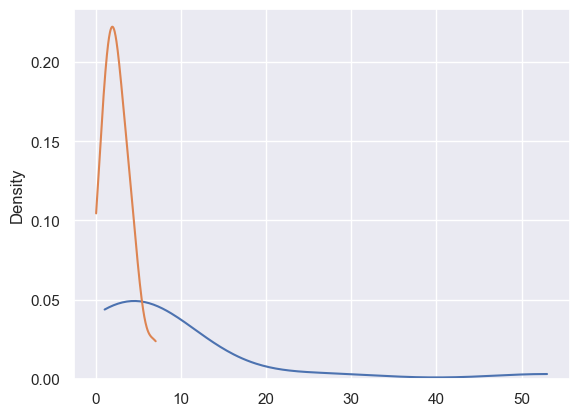

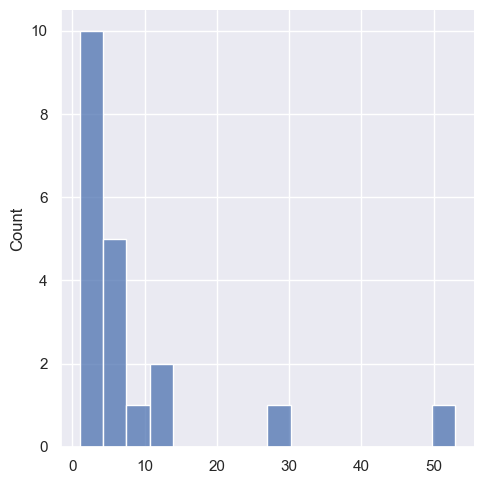

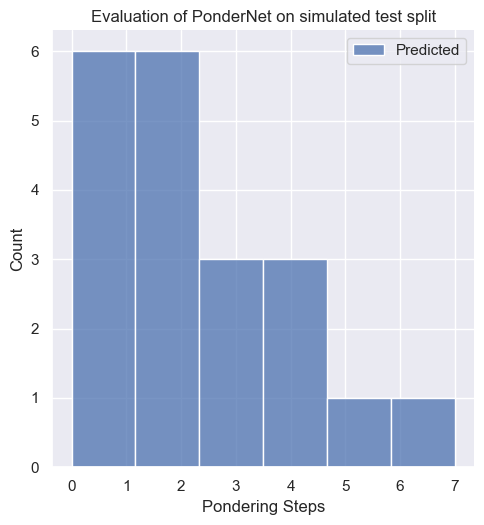

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(rt_test.detach(), label='Original (test)', cut=0)
sns.kdeplot(rt_test_pred.detach(), label='Predicted', cut=0)

sns.displot(rt_test.detach(), label='Original (test)')
sns.displot(rt_test_pred.detach(), label='Predicted')
# sns.kdeplot(rt_train, label='original', cut=0)
# sns.kdeplot(rt_test, label='original test', cut=0)

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('Pondering Steps')

plt.legend()
plt.show()